In [23]:
import time
import tqdm
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
from torchvision import transforms

In [4]:
torch.manual_seed(42)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

In [8]:
trainSet = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

100%|██████████| 9912422/9912422 [00:35<00:00, 276422.42it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 4917818.03it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:13<00:00, 125151.67it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 2629835.56it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [9]:
batchSize = 32
trainLoader = torch.utils.data.DataLoader(
    trainSet, batch_size=batchSize, shuffle=True
)

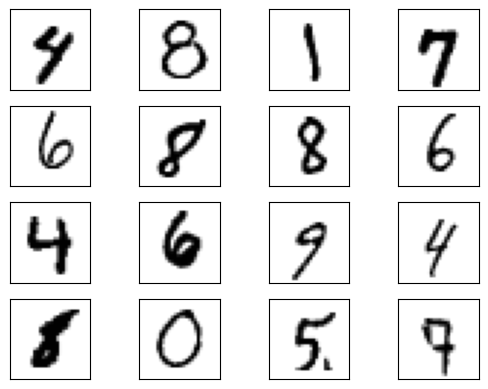

In [14]:
realSamples, mnistLabels = next(iter(trainLoader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(realSamples[i+7].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [15]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

In [17]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

In [18]:
discriminator = Discriminator().to(device=device)
generator = Generator().to(device=device)

In [19]:
lr = 0.0001
numEpochs = 50
lossFunction = nn.BCELoss()

optimizerDiscriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizerGenerator = torch.optim.Adam(generator.parameters(), lr=lr)

In [24]:
t1 = time.time()
for epoch in tqdm.trange(numEpochs, colour = "red"):
    for n, (realSamples, mnistLabels) in enumerate(trainLoader):
        realSamples = realSamples.to(device=device)
        realSampleLabels = torch.ones((batchSize, 1)).to(
            device=device
        )
        latentSamples = torch.randn((batchSize, 100)).to(
            device=device
        )
        generatedSamples = generator(latentSamples)
        generatedSampleLabels = torch.zeros((batchSize, 1)).to(
            device=device
        )
        allSamples = torch.cat((realSamples, generatedSamples))
        allSampleLabels = torch.cat(
            (realSampleLabels, generatedSampleLabels)
        )

        discriminator.zero_grad()
        outputDiscriminator = discriminator(allSamples)
        lossDiscriminator = lossFunction(
            outputDiscriminator, allSampleLabels
        )
        lossDiscriminator.backward()
        optimizerDiscriminator.step()

        latent_space_samples = torch.randn((batchSize, 100)).to(
            device=device
        )
        generator.zero_grad()
        generatedSamples = generator(latent_space_samples)
        outputDiscriminatorGenerated = discriminator(generatedSamples)
        lossGenerator = lossFunction(
            outputDiscriminatorGenerated, realSampleLabels
        )
        lossGenerator.backward()
        optimizerGenerator.step()
        if n == batchSize - 1:
            print(f"Epoch: {epoch} Loss D.: {lossDiscriminator}")
            print(f"Epoch: {epoch} Loss G.: {lossGenerator}")
t2 = time.time()
print("ExecTimme: ", (t2-t1))

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 Loss D.: 0.1704532504081726
Epoch: 0 Loss G.: 1.3253724575042725


  2%|▏         | 1/50 [02:15<1:50:34, 135.40s/it]

Epoch: 1 Loss D.: 0.030368011444807053
Epoch: 1 Loss G.: 4.751555919647217


  4%|▍         | 2/50 [04:19<1:43:07, 128.91s/it]

Epoch: 2 Loss D.: 0.06913873553276062
Epoch: 2 Loss G.: 5.713351726531982


  6%|▌         | 3/50 [06:36<1:43:49, 132.54s/it]

Epoch: 3 Loss D.: 0.009987259283661842
Epoch: 3 Loss G.: 5.308529376983643


  8%|▊         | 4/50 [08:56<1:43:47, 135.39s/it]

Epoch: 4 Loss D.: 0.030876770615577698
Epoch: 4 Loss G.: 5.70640230178833


 10%|█         | 5/50 [12:06<1:56:27, 155.28s/it]

Epoch: 5 Loss D.: 0.01640326716005802
Epoch: 5 Loss G.: 7.7451276779174805


 12%|█▏        | 6/50 [15:04<1:59:25, 162.86s/it]

Epoch: 6 Loss D.: 1.5107957978761592e-23
Epoch: 6 Loss G.: 69.07080078125


 14%|█▍        | 7/50 [19:28<2:20:23, 195.90s/it]

Epoch: 7 Loss D.: 4.459175895141993e-24
Epoch: 7 Loss G.: 68.61770629882812


 16%|█▌        | 8/50 [24:16<2:37:37, 225.18s/it]

Epoch: 8 Loss D.: 6.430402319481719e-22
Epoch: 8 Loss G.: 67.1584701538086


In [ ]:
latentSamples = torch.randn(batchSize, 100).to(device=device)
generatedSamples = generator(latentSamples)

In [ ]:
generatedSamples = generatedSamples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generatedSamples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])